# Example Likelihood Test

This notebook tests the implementation of a standard minimal firecrown likelihood which can be used with the blinding library.

In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pylab as plt
from firecrown.likelihood.likelihood import load_likelihood
from firecrown.likelihood.likelihood import load_likelihood_from_module_type
from firecrown.likelihood.likelihood import NamedParameters
from firecrown.parameters import ParamsMap
from firecrown.utils import save_to_sacc
import numpy as np
import sacc
import pathlib
import pyccl as ccl
from firecrown.modeling_tools import ModelingTools
import firecrown
import sys
import os
from copy import deepcopy

from blinding import Smokescreen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
sys.path.append("../examples/cosmic_shear/")
import cosmicshear_likelihood

First let's try to pass the sacc as a string

In [33]:
sacc_file = "../examples/cosmic_shear/cosmicshear_sacc.fits"
build_parameters = NamedParameters({
    "sacc_data": sacc_file,
})
likelihood, tools = load_likelihood_from_module_type(cosmicshear_likelihood, build_parameters)

/opt/homebrew/Caskroom/miniforge/base/envs/desc_blinding/lib/python3.11/site-packages/sacc/sacc.py:974: UserWarning: No bandpower windows associated to these data
  warnings.warn("No bandpower windows associated to these data")


In [34]:
build_parameters.data['sacc_data']

'../examples/cosmic_shear/cosmicshear_sacc.fits'

In [35]:
likelihood.get_data_vector()

array([8.68664926e-09, 4.83660661e-09, 2.14902577e-09, 8.38689728e-10,
       3.29653471e-10, 1.35937954e-10, 4.99982193e-11, 1.39742692e-11,
       3.07364829e-12, 6.00642443e-13, 1.45234282e-08, 9.00288602e-09,
       4.26223992e-09, 1.63728386e-09, 6.32897033e-10, 2.63589025e-10,
       1.00965763e-10, 3.14823356e-11, 7.41193727e-12, 1.46985175e-12,
       2.94891553e-08, 2.09520287e-08, 1.09428163e-08, 4.47545278e-09,
       1.67488389e-09, 6.67403009e-10, 2.66481401e-10, 9.29506616e-11,
       2.43582380e-11, 5.16257092e-12])

Now let's try to pass the loaded sacc object

In [36]:
sacc_file = "../examples/cosmic_shear/cosmicshear_sacc.fits"
sacc_data = sacc.Sacc.load_fits(sacc_file)
build_parameters =  NamedParameters({
    "sacc_data": sacc_data,
})
likelihood, tools = load_likelihood_from_module_type(cosmicshear_likelihood, build_parameters)

In [37]:
likelihood.get_data_vector()

array([8.68664926e-09, 4.83660661e-09, 2.14902577e-09, 8.38689728e-10,
       3.29653471e-10, 1.35937954e-10, 4.99982193e-11, 1.39742692e-11,
       3.07364829e-12, 6.00642443e-13, 1.45234282e-08, 9.00288602e-09,
       4.26223992e-09, 1.63728386e-09, 6.32897033e-10, 2.63589025e-10,
       1.00965763e-10, 3.14823356e-11, 7.41193727e-12, 1.46985175e-12,
       2.94891553e-08, 2.09520287e-08, 1.09428163e-08, 4.47545278e-09,
       1.67488389e-09, 6.67403009e-10, 2.66481401e-10, 9.29506616e-11,
       2.43582380e-11, 5.16257092e-12])

In [38]:
list(likelihood.required_parameters().get_params_names())

['trc0_delta_z', 'trc1_delta_z']

## Testing now with the blinding library

In [46]:
cosmo = ccl.CosmologyVanillaLCDM()
syst_dict = {
    "trc1_delta_z": 0.1,
    "trc0_delta_z": 0.1,
    }
shift_dict = {"Omega_c": 0.34, "sigma8": 0.85}
sck = Smokescreen(cosmo, syst_dict, cosmicshear_likelihood, shift_dict, sacc_data)

/opt/homebrew/Caskroom/miniforge/base/envs/desc_blinding/lib/python3.11/site-packages/sacc/sacc.py:974: UserWarning: No bandpower windows associated to these data
  warnings.warn("No bandpower windows associated to these data")


In [47]:
sck.calculate_blinding_factor()

/opt/homebrew/Caskroom/miniforge/base/envs/desc_blinding/lib/python3.11/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (50) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


In [48]:
blinded_datavect = sck.apply_blinding_to_likelihood_datavec()

In [49]:
sck.likelihood.get_sacc_indices()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

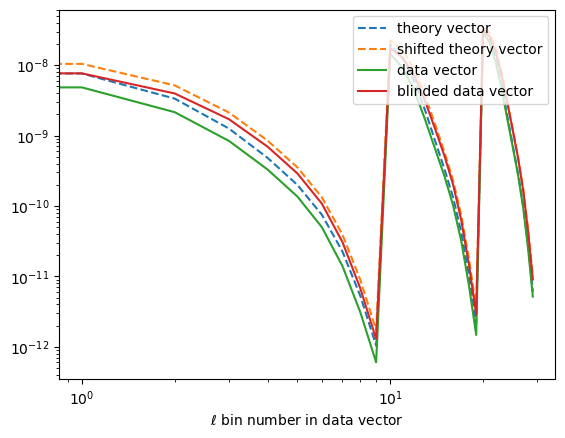

In [53]:
plt.figure()
plt.loglog(sck.theory_vec_fid, ls='--', label='theory vector')
plt.loglog(sck.theory_vec_blind, ls='--', label='shifted theory vector')
plt.loglog(sck.likelihood.get_data_vector(), label='data vector')
plt.loglog(blinded_datavect, label='blinded data vector')
plt.legend(loc=1)
plt.xlabel(r'$\ell$ bin number in data vector')
plt.ylabel(r'$C_{\ell}$')
plt.show()

In [30]:
sacc_test.sa